In [1]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

from IPython.display import display,Image, Latex
from __future__ import division
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
from IPython.display import clear_output

import time

from IPython.display import display,Image, Latex

from IPython.display import clear_output


import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc
import h5py

import sympy as sym

    
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }

from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)

class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }

from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)

<h1>Vortex Identification in CFD</h1>
<h2>Vortex Definition</h2> 
Vortices are both the most interesting and frustrating feature of fluid dynamics. Turbulence, mixing cannot happen without them. The frustration comes from the definition of what a vortex is, or rather the lack of rigorous mathematical definition. A vortical structure is generally defined as:
<ul>
<li>The vorticity concentration $\omega$ should be high enough so that a local roll-up of the surrounding fluid is possible,</li>
<li>It should approximately keep its shape during a time $T_c$ long enough compared to the local turnover time $\omega^-1$,</li>
</ul>

In the words of John Kim, Prof. at UCLA and one of Pioneer of direct numerical simulation: "you'll know one (vortex) when you see one".

<h2>Vorticity</h2>
Vorticity should be viewed as the actual or potential inclination of fluid particles to follow rotational motions. The definition of vorticity is:
<p class='alert alert-danger'>
$$
\vec{\omega}=\vec{\nabla}\times \vec{u}=(\partial_yw-\partial_zv)\vec{e}_x+(\partial_zu-\partial_xw)\vec{e}_y
+(\partial_xv-\partial_yu)\vec{e}_z
$$
</p>

Note that in 2D, vorticity is a vector orthogonal to the plane of magnitude:
<p class='alert alert-danger'>
$$
\omega=\partial_xv-\partial_yu
$$
</p>
In a 2D laminar boundary layer, there are obviously not vortices, but vorticity is non zero. In fact the vorticity reaches its highest magnitude at the wall, where $\omega = -\partial_yu$, hence the use of the word potential earlier.
This shows that the use of high vorticity threshold to identify vortical structures may not necessarily identified actual vortices.
<h2>Pressure</h2>
Another form of the Navier-Stokes equation is

$$
\partial_t\vec{u}+\vec{\omega}\times\vec{u}=-\frac{1}{\rho}\vec{\nabla}P+\nu\nabla^2\vec{u}
$$

with $P=p+\frac{1}{2}\rho u^2$. Consider a vortex in a low-viscosity fluid ($nu\rightarrow0$. The lifetime of the vortex is long, which means that the local temporal variation of velocity is small. The above equation reduces to:

<p class='alert alert-danger'>
$$
\vec{\omega}\times\vec{u}=-\frac{1}{\rho}\vec{\nabla}P
$$
</p>

In a vortex, the left hand side is positive results into an inward radial vector, therefore the gradient of pressure is radial and outward. Pressure grows as we are moving away from the center of the vortex, or in other words,

<p class='alert alert-danger'>
A vortex is a region of low pressure.
</p>



<h2>Problem 1</h2>

Using the two flow fields provided in the folder data, named 02.007.h5 and 02.029.h5, and the functions provided below, try to identify vortices in these two snapshots of a natural convection flow.

In [2]:
""" Compute the derivation matrix for derivatives on a non-uniform grid
    Step 1: Given a mesh x, compute the matrix D = nufd(x)
    Step 2: Compute derivative of u defined on mesh x: dxu = D*u
"""
from scipy.sparse import csr_matrix
def nufd(x):
    n = len(x)
    h = x[1:]-x[:n-1]
    a0 = -(2*h[0]+h[1])/(h[0]*(h[0]+h[1]))
    ak = -h[1:]/(h[:n-2]*(h[:n-2]+h[1:]))
    an = h[-1]/(h[-2]*(h[-1]+h[-2]))
    b0 = (h[0]+h[1])/(h[0]*h[1]) 
    bk = (h[1:] - h[:n-2])/(h[:n-2]*h[1:])
    bn = -(h[-1]+h[-2])/(h[-1]*h[-2])
    c0 = -h[0]/(h[1]*(h[0]+h[1]))
    ck = h[:n-2]/(h[1:]*(h[:n-2]+h[1:]))
    cn = (2*h[-1]+h[-2])/(h[-1]*(h[-2]+h[-1]))
    val  = np.hstack((a0,ak,an,b0,bk,bn,c0,ck,cn))
    row = np.tile(np.arange(n),3)
    dex = np.hstack((0,np.arange(n-2),n-3))
    col = np.hstack((dex,dex+1,dex+2))
    D = csr_matrix((val,(row,col)),shape=(n,n))
    return D

""" Compute the velocity gradient vector A[i,j,:,:] where
    i is the direction of derivation
    j is the index denoting the velocity component
    the last two indices are the z (wall normal) and x (horizontal) coordinates of computational nodes
"""
def compute_A(u,w):
    global Nx,Nz,dx,Dzu,dzpin
    A = np.zeros((2,2,Nz,Nx))
    #A[i,j,:,:] =d_iu_j
    A[0,0,:,:] = (u[1:-1,1:-1] - u[1:-1,0:-2])/dx #dxu
    A[0,1,:,:] = 0.5*(w[0:-2,1:-1] - w[0:-2,0:-2] \
                     +w[1:-1,1:-1] - w[1:-1,0:-2])/dx
    dzu = np.zeros((Nz+2,Nx+2))
    for i in range(Nx+2):
        dzu[:,i] = Dzu*u[:,i]
    A[1,0,:,:] = 0.5*(dzu[1:-1,1:-1]+dzu[1:-1,0:-2])
    A[1,1,:,:] = (w[1:-1,1:-1] - w[0:-2,1:-1])/dzpin[:,:]
    return A

In [3]:
""" Read mesh
"""
folder = "./Data/"
file = h5py.File(folder+'grid.h5','r+')
XZ = file.get('/Coor')
XZ = np.array(XZ)
file.close()
Nx = np.shape(XZ)[2]-2
Nz = np.shape(XZ)[1]-2
zu = XZ[3,:,0]
zw = XZ[4,:,0]
zp = XZ[5,:,0]
dx = XZ[0,0,1] - XZ[0,0,0]
Xp = XZ[2,1:-1,1:-1]
Zp = XZ[5,1:-1,1:-1]
Dzu = nufd(zu)
Dzw = nufd(zw)
Dzp = nufd(zp)
dzpin = XZ[5,1:-1,1:-1] - XZ[5,0:-2,1:-1]

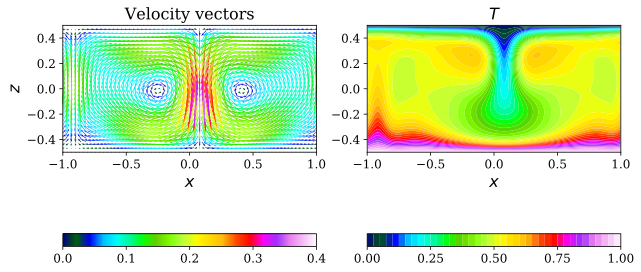

In [4]:
""" Plot Temperature contours and velocity vectors
"""

# Interpolation to avoid having too many vectors
Nxnew = 64
Nznew = 33
from scipy import interpolate
xpold = np.copy(Xp[0,:])
zpold = np.copy(Zp[:,0])
xnew = np.linspace(xpold[0],xpold[-1] ,Nxnew)
znew = np.linspace(zpold[0],zpold[-1], Nznew)
Xnew, Znew = np.meshgrid(xnew,znew)
def interpolate_field(qp):
    global xpold, zpold, xnew, znew
    f = interpolate.RectBivariateSpline(zpold, xpold, qp)
    return f(znew,xnew)

# fname = "02.007.h5"
# pltname = "fig.02.007.png"
fname = "02.029.h5"
pltname = "fig.02.029.png"
file = h5py.File(folder+fname,'r')
u = file['u'][:]
w = file['w'][:]
p = file['p'][:]
T = file['T'][:]
Re = file['u'].attrs['Re']
Pr = file['u'].attrs['Pr']
tlocal = file['u'].attrs['time']
file.close()

# compute variables at cell centers
up = np.zeros((Nz,Nx))
Tp = np.copy(T[1:-1,1:-1])
pp = np.copy(p[1:-1,1:-1])
wp = np.zeros((Nz,Nx))
wp = 0.5*(w[1:-1,1:-1]+w[0:-2,1:-1])
up = 0.5*(u[1:-1,1:-1]+u[1:-1,0:-2])

fig = plt.figure(num=None, figsize=(10, 10), dpi=160, facecolor='w', edgecolor='k')
ax0 = plt.subplot2grid((1, 2), (0, 0))
ax1 = plt.subplot2grid((1, 2), (0, 1))



upnew = interpolate_field(up)
wpnew = interpolate_field(wp)
magvel = np.sqrt(np.power(upnew,2)+np.power(wpnew,2))
lev = np.linspace(0,0.4,41)
tickcmp = np.linspace(0,0.4,5)
im0 = ax0.quiver(Xnew, Znew, upnew, wpnew, magvel, pivot='mid', scale = 1.5
                 ,clim = [0, 0.4] , cmap = 'gist_ncar')
fig.colorbar(im0, ax = ax0, ticks = tickcmp, orientation = 'horizontal')
ax0.set_aspect('equal')
ax0.set_xlabel('$x$', fontdict = fontlabel)
ax0.set_ylabel('$z$', fontdict = fontlabel)
ax0.set_title(r"Velocity vectors", fontdict=fontlabel)
ax0.set_ylim(-0.5,0.5)
ax0.set_xlim(-1,1)
    

lev = np.linspace(0,1,41)
tickcmp = np.linspace(0,1,5)
im1 = ax1.contourf(Xp, Zp, Tp, levels=lev, cmap = 'gist_ncar')
ax1.set_aspect('equal')
ax1.set_xlabel('$x$', fontdict = fontlabel)
fig.colorbar(im1, ax = ax1, ticks = tickcmp, orientation = 'horizontal')
ax1.set_title(r"$T$", fontdict=fontlabel)
ax1.set_ylim(-0.5,0.5)
ax1.set_xlim(-1,1)
    

# plt.savefig(pltname, bbox_inches='tight')
plt.show()

    

<ol>
<li>How many vortices do you see?</li>
<li>Plot side by side the vorticity and pressure with a superimposition of velocity vectors, what do you observe?</li>
<li>Calculate the mean pressure by averaging in the horizontal direction
$$
\overline{p}(z)=\frac{1}{L_x}\int_{-L_x/2}^{+L_x/2}p\,dx
$$
($L_x$ is the horizontal length of the computational domain), and substract this mean pressure to the pressure field. Can you observe low pressure regions where you would expect to see vortices?</li>
<li>What is your general impression of the vorticity and pressure to identify vortices?</li>
</ol>

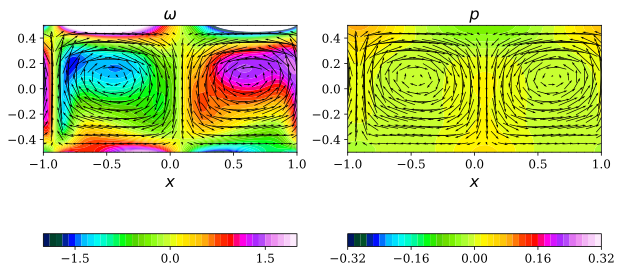

In [17]:
# Interpolation to avoid having too many vectors
Nxnew = 32
Nznew = 16
from scipy import interpolate
xpold = np.copy(Xp[0,:])
zpold = np.copy(Zp[:,0])
xnew = np.linspace(xpold[0],xpold[-1] ,Nxnew)
znew = np.linspace(zpold[0],zpold[-1], Nznew)
Xnew, Znew = np.meshgrid(xnew,znew)
def interpolate_field(qp):
    global xpold, zpold, xnew, znew
    f = interpolate.RectBivariateSpline(zpold, xpold, qp)
    return f(znew,xnew)
fname = "02.007.h5"
pltname = "figvortp.02.007.png"
file = h5py.File(folder+fname,'r')
u = file['u'][:]
w = file['w'][:]
p = file['p'][:]
T = file['T'][:]
Re = file['u'].attrs['Re']
Pr = file['u'].attrs['Pr']
tlocal = file['u'].attrs['time']
file.close()

# compute variables at cell centers
up = np.zeros((Nz,Nx))
Tp = np.copy(T[1:-1,1:-1])
pp = np.copy(p[1:-1,1:-1])
wp = np.zeros((Nz,Nx))
wp = 0.5*(w[1:-1,1:-1]+w[0:-2,1:-1])
up = 0.5*(u[1:-1,1:-1]+u[1:-1,0:-2])

""" This is where you should compute the pressure fluctuations"""

pmean = np.mean(pp, axis = 1)

for k in range(Nz):
    pp[k,:] -= pmean[k]


fig = plt.figure(num=None, figsize=(10, 10), dpi=160, facecolor='w', edgecolor='k')
ax0 = plt.subplot2grid((1, 2), (0, 0))
ax1 = plt.subplot2grid((1, 2), (0, 1))

A = np.zeros((2,2,Nz,Nx))
A = compute_A(u,w)
""" This is where you should compute vorticity"""
omega = np.zeros((Nz,Nx))

omega = A[0,1,:,:] - A[1,0,:,:]
upnew = interpolate_field(up)
wpnew = interpolate_field(wp)

lev = np.linspace(-2,2,41)
tickcmp = np.linspace(-3,3,5)
im0 = ax0.contourf(Xp, Zp, omega, levels = lev, cmap = 'gist_ncar')
ax0.set_aspect('equal')
ax0.set_xlabel('$x$', fontdict = fontlabel)
fig.colorbar(im0, ax = ax0, ticks = tickcmp, orientation = 'horizontal')
ax0.set_title(r"$\omega$", fontdict=fontlabel)
ax0.set_ylim(-0.5,0.5)
ax0.set_xlim(-1,1)
ax0.quiver(Xnew, Znew, upnew, wpnew, pivot='mid', scale = 1.5)
    


lev = np.linspace(-0.32,0.32,41)
tickcmp = np.linspace(-0.32,0.32,5)
im1 = ax1.contourf(Xp, Zp, pp, levels = lev, cmap = 'gist_ncar')
ax1.set_aspect('equal')
ax1.set_xlabel('$x$', fontdict = fontlabel)
fig.colorbar(im1, ax = ax1, ticks = tickcmp, orientation = 'horizontal')
ax1.set_title(r"$p$", fontdict=fontlabel)
ax1.set_ylim(-0.5,0.5)
ax1.set_xlim(-1,1)
ax1.quiver(Xnew, Znew, upnew, wpnew, pivot='mid', scale = 1.5)
    

# plt.savefig(pltname, bbox_inches='tight')
plt.show()

In [ ]:
# Interpolation to avoid having too many vectors
Nxnew = 32
Nznew = 16
from scipy import interpolate
xpold = np.copy(Xp[0,:])
zpold = np.copy(Zp[:,0])
xnew = np.linspace(xpold[0],xpold[-1] ,Nxnew)
znew = np.linspace(zpold[0],zpold[-1], Nznew)
Xnew, Znew = np.meshgrid(xnew,znew)
def interpolate_field(qp):
    global xpold, zpold, xnew, znew
    f = interpolate.RectBivariateSpline(zpold, xpold, qp)
    return f(znew,xnew)
fname = "02.007.h5"
pltname = "figvortp.02.007.png"
file = h5py.File(folder+fname,'r')
u = file['u'][:]
w = file['w'][:]
p = file['p'][:]
T = file['T'][:]
Re = file['u'].attrs['Re']
Pr = file['u'].attrs['Pr']
tlocal = file['u'].attrs['time']
file.close()

# compute variables at cell centers
up = np.zeros((Nz,Nx))
Tp = np.copy(T[1:-1,1:-1])
pp = np.copy(p[1:-1,1:-1])
wp = np.zeros((Nz,Nx))
wp = 0.5*(w[1:-1,1:-1]+w[0:-2,1:-1])
up = 0.5*(u[1:-1,1:-1]+u[1:-1,0:-2])

pmean = np.zeros(Nz)
pmean = np.mean(pp, axis = 1)

for k in range(Nz):
    pp[k,:] -= pmean[k]

fig = plt.figure(num=None, figsize=(10, 10), dpi=160, facecolor='w', edgecolor='k')
ax0 = plt.subplot2grid((1, 2), (0, 0))
ax1 = plt.subplot2grid((1, 2), (0, 1))

A = np.zeros((2,2,Nz,Nx))
A = compute_A(u,w)

omega = np.zeros((Nz,Nx))
omega = A[0,1,:,:] - A[1,0,:,:]

upnew = interpolate_field(up)
wpnew = interpolate_field(wp)

lev = np.linspace(-2,2,41)
tickcmp = np.linspace(-2,2,5)
im0 = ax0.contourf(Xp, Zp, omega, levels = lev, cmap = 'gist_ncar')
ax0.set_aspect('equal')
ax0.set_xlabel('$x$', fontdict = fontlabel)
fig.colorbar(im0, ax = ax0, ticks = tickcmp, orientation = 'horizontal')
ax0.set_title(r"$\omega$", fontdict=fontlabel)
ax0.set_ylim(-0.5,0.5)
ax0.set_xlim(-1,1)
ax0.quiver(Xnew, Znew, upnew, wpnew, pivot='mid', scale = 1.5)
    

lev = np.linspace(-0.025,0.025,41)
tickcmp = np.linspace(-0.025,0.025,5)
# lev = np.linspace(-0.32,0.32,41)
# tickcmp = np.linspace(-0.32,0.32,5)
im1 = ax1.contourf(Xp, Zp, pp, levels = lev, cmap = 'gist_ncar')
ax1.set_aspect('equal')
ax1.set_xlabel('$x$', fontdict = fontlabel)
fig.colorbar(im1, ax = ax1, ticks = tickcmp, orientation = 'horizontal')
ax1.set_title(r"$p$", fontdict=fontlabel)
ax1.set_ylim(-0.5,0.5)
ax1.set_xlim(-1,1)
ax1.quiver(Xnew, Znew, upnew, wpnew, pivot='mid', scale = 1.5)
    

# plt.savefig(pltname, bbox_inches='tight')
plt.show()

<h2>The $Q$-Criterion</h2>

One of the most popular vortex criterion is the $Q$-criterion. $Q$ is the second invariant of the velocity gradient
tensor

$$
A_{ij}=\partial_ju_i=S_{ij}+\Omega_{ij}.
$$

where $S$ and $\Omega$ are the strain rate and rotation rate tensors, respectively. The invariants of a tensor are the coefficients of the characteristic equation of the tensor:

$$
\lambda^3+P\lambda^2+Q\lambda+R = 0
$$

The invariants are:

\begin{eqnarray}
P &=& -A_{ii}\\
Q &=& -\frac{1}{2}A_{ij}A_{ji}\\
R &=& -\frac{1}{3}A_{ij}A_{jk}A_{ki}
\end{eqnarray}

Note for an incompressible flow $P=0$. The discriminant of the characteristic equation

$$
D=\frac{27}{4}R^2+Q^3
$$

For a cubic equation, $D>0$ leads to 2 complex eigenvalues.

The connection between $A_{ij}$ and flow topology comes from the relation between a particle position $x_i$, the particle velocity $d_tx_i=\dot{x_i}$

$$
\dot{x_i}=A_{ij}x_j
$$

Two complex eigenvalyes means that the streamlines are locally spiralling. While $D>0$ is a possible criterion, a better criterion is

<p class='alert alert-danger'>
$$
Q>Q_{th}>0
$$
</p>

where $Q_{th}$ is a subjective value. Because that's the best we can do in the absence of mathematical definition for a vortex.

To be understand $Q$, consider a different form of $Q$,

<p class='alert alert-danger'>
$$
Q = \frac{1}{2}\left(\Omega^2-S^2\right)
$$
</p>

or the difference between the rotation rate and strain rate (in squared norm form). Where $Q$ is positive, the rotation rate dominates the strain rate. $Q_{th}$ depends on the flow geometry, Reynolds number, etc...

Additionally, in an incompressible flow, 

<p class='alert alert-danger'>
$$
Q = \frac{1}{2\rho}\nabla^2p=\frac{1}{2\rho}\partial_i\partial_ip
$$
</p>

The second test derivative implies that the pressure field is locally convex when $Q>0$ (positive curvature) therefore a region of positive $Q$ includes a local minimum of pressure. 

<h2>Problem 2</h2>

<ol>
<li>Code and plot contours of $Q$. Adjust the colormap scale to highlight the vortices.</li>
<li>Compute the Nusselt number which you will calculate from the equation:

$$
Nu=1+\frac{1}{RePr}\frac{1}{L_xH}\int_{-H/2}^{+H/2}\int_{-L_x/2}^{+L_x/2}wT\,dxdz
$$

using the numpy function mean for the first integral trapz (you will need the coordinates zp[1:-1]) for the second integral. $L_x$ and $H$ are the horizontal length and the height of the computational domain, respectively. 

<li>Discuss the relation between the low Nusselt number state (02.007.h5) and the high Nusselt number state (02.029.h5).</li>
</ol>

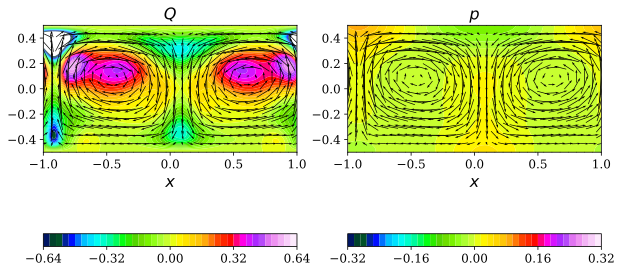

In [14]:
# Interpolation to avoid having too many vectors
Nxnew = 32
Nznew = 16
from scipy import interpolate
xpold = np.copy(Xp[0,:])
zpold = np.copy(Zp[:,0])
xnew = np.linspace(xpold[0],xpold[-1] ,Nxnew)
znew = np.linspace(zpold[0],zpold[-1], Nznew)
Xnew, Znew = np.meshgrid(xnew,znew)
def interpolate_field(qp):
    global xpold, zpold, xnew, znew
    f = interpolate.RectBivariateSpline(zpold, xpold, qp)
    return f(znew,xnew)
fname = "02.007.h5"
pltname = "figvortp.02.007.png"
file = h5py.File(folder+fname,'r')
u = file['u'][:]
w = file['w'][:]
p = file['p'][:]
T = file['T'][:]
Re = file['u'].attrs['Re']
Pr = file['u'].attrs['Pr']
tlocal = file['u'].attrs['time']
file.close()

# compute variables at cell centers
up = np.zeros((Nz,Nx))
Tp = np.copy(T[1:-1,1:-1])
pp = np.copy(p[1:-1,1:-1])
wp = np.zeros((Nz,Nx))
wp = 0.5*(w[1:-1,1:-1]+w[0:-2,1:-1])
up = 0.5*(u[1:-1,1:-1]+u[1:-1,0:-2])

""" This is where you should compute the pressure fluctuations"""
pmean = np.zeros(Nz)
pmean = np.mean(pp, axis = 1)

for k in range(Nz):
    pp[k,:] -= pmean[k]
fig = plt.figure(num=None, figsize=(10, 10), dpi=160, facecolor='w', edgecolor='k')
ax0 = plt.subplot2grid((1, 2), (0, 0))
ax1 = plt.subplot2grid((1, 2), (0, 1))

A = np.zeros((2,2,Nz,Nx))
A = compute_A(u,w)
""" This is where you should compute Q"""
Q = np.zeros((Nz,Nx))

for i in range(2):
    for j in range(2):
        Q += -0.5*(A[i,j,:,:]*A[j,i,:,:])

upnew = interpolate_field(up)
wpnew = interpolate_field(wp)

lev = np.linspace(-0.64,0.64,41)
tickcmp = np.linspace(-0.64,0.64,5)
im0 = ax0.contourf(Xp, Zp, Q, levels = lev, cmap = 'gist_ncar')
ax0.set_aspect('equal')
ax0.set_xlabel('$x$', fontdict = fontlabel)
fig.colorbar(im0, ax = ax0, ticks = tickcmp, orientation = 'horizontal')
ax0.set_title(r"$Q$", fontdict=fontlabel)
ax0.set_ylim(-0.5,0.5)
ax0.set_xlim(-1,1)
ax0.quiver(Xnew, Znew, upnew, wpnew, pivot='mid', scale = 1.5)
    


lev = np.linspace(-0.32,0.32,41)
tickcmp = np.linspace(-0.32,0.32,5)
im1 = ax1.contourf(Xp, Zp, pp, levels = lev, cmap = 'gist_ncar')
ax1.set_aspect('equal')
ax1.set_xlabel('$x$', fontdict = fontlabel)
fig.colorbar(im1, ax = ax1, ticks = tickcmp, orientation = 'horizontal')
ax1.set_title(r"$p$", fontdict=fontlabel)
ax1.set_ylim(-0.5,0.5)
ax1.set_xlim(-1,1)
ax1.quiver(Xnew, Znew, upnew, wpnew, pivot='mid', scale = 1.5)
    

# plt.savefig(pltname, bbox_inches='tight')
plt.show()